# Goal: Create customer profiles using clustering methods and customer purchase history

In [3]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import spearmanr
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 

import wrangle_profiles as wp

##  Wrangle

The original data contained transaction information for LGS customers from 2001-2004. Items purchased in ‘purchase’ transactions were sorted into one of nine categories. <br>
<br>
Central categories representing major gaming interests include:
* Board Games 
* Role Playing Games
* Trading Card Games
* Tabletop Minis Games
* Modeling_Supplies
<a/>

Feeder Categories represent categories that support or are adjacent to major interests include:
* Accessories
* Concessions
* Game Room Rentals
<a/>

Items that could not be classified were categorized as 
* Other
<a/>

In [4]:
df = wp.get_prepared_profiles_data()

## Explore 

### What does an average customer's spending habits look like?

In [12]:
cats = ['accessories', 
        'board_games', 
        'concessions', 
        'modeling_supplies',
        'role_playing_games', 
        'minis_models', 
        'trading_card_games', 
        'game_room_rental',
        'net_sales']


df[cats].describe()[1:3]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,game_room_rental,net_sales
mean,1.715006,0.474149,4.362547,1.569987,0.165826,0.541614,2.228247,0.059899,172.634332
std,4.503849,1.391602,18.823379,8.263589,0.877833,2.303441,7.990032,0.564630,442.719224


Given the mean and relatively large standard deviation across all categories, penning down the habbits of an 'average' would be unhelpful due to the large variance. Moving forward it will be my goal to identify population clusters were the variance is less severe.

### How many customers does each category appeal to? 

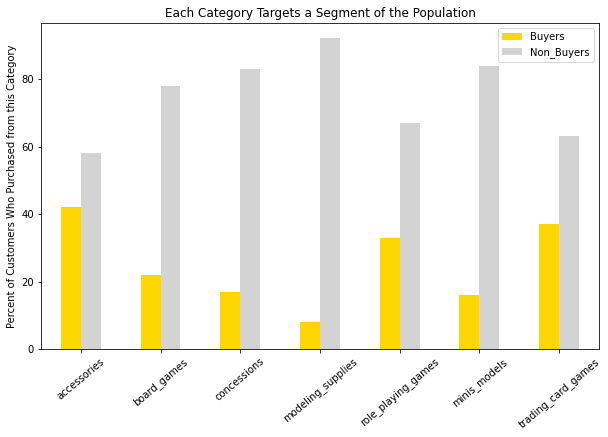

In [7]:
cats = ['accessories', 
        'board_games', 
        'concessions', 
        'modeling_supplies',
        'role_playing_games', 
        'minis_models', 
        'trading_card_games']

buyers = [round(len(df[df['accessories'] > 0]) / len(df)*100),
          round(len(df[df['board_games'] > 0]) / len(df)*100),
          round(len(df[df['modeling_supplies'] > 0]) / len(df)*100),
          round(len(df[df['role_playing_games'] > 0]) / len(df)*100),
          round(len(df[df['concessions'] > 0]) / len(df)*100),
          round(len(df[df['minis_models'] > 0]) / len(df)*100),
          round(len(df[df['trading_card_games'] > 0]) / len(df)*100)]
    
non_buyers = [round(len(df[df['accessories'] == 0]) / len(df)*100),
              round(len(df[df['board_games'] == 0]) / len(df)*100),
              round(len(df[df['modeling_supplies'] == 0]) / len(df)*100),
              round(len(df[df['role_playing_games'] == 0]) / len(df)*100),
              round(len(df[df['concessions'] == 0]) / len(df)*100),
              round(len(df[df['minis_models'] == 0]) / len(df)*100),
              round(len(df[df['trading_card_games'] == 0]) / len(df)*100)]

data = { 'Category':cats,
         'Buyers':buyers,
         'Non_Buyers':non_buyers}

df_data = pd.DataFrame(data)

df_data.set_index('Category', inplace=True)

df_data.plot(kind='bar', figsize=(10, 6), color = ['gold', 'lightgrey'])

plt.xticks(rotation=40)

plt.xlabel('')
plt.ylabel('Percent of Customers Who Purchased from this Category')
plt.title('Each Category Targets a Segment of the Population')


plt.show()

In [13]:
print (buyers)

[42, 22, 17, 8, 33, 16, 37]


### Are customers who buy one type of product more or less likely to buy a different type of product?

In [8]:
for cat_1 in cats:

    df_cata = df[df[cat_1] > 0]

    total = len(df_cata)
    
    print()
    print(f'{total} Customers bought one or more {cat_1.upper()}')

    for cat_2 in cats:

        if cat_1 != cat_2:

            print(f'{round(len(df_cata[df_cata[cat_2] > 0])/total*100)}% also bought one or more {cat_2}')


667 Customers bought one or more ACCESSORIES
21% also bought one or more board_games
39% also bought one or more concessions
16% also bought one or more modeling_supplies
13% also bought one or more role_playing_games
18% also bought one or more minis_models
45% also bought one or more trading_card_games

347 Customers bought one or more BOARD_GAMES
39% also bought one or more accessories
34% also bought one or more concessions
17% also bought one or more modeling_supplies
12% also bought one or more role_playing_games
18% also bought one or more minis_models
22% also bought one or more trading_card_games

531 Customers bought one or more CONCESSIONS
49% also bought one or more accessories
22% also bought one or more board_games
22% also bought one or more modeling_supplies
12% also bought one or more role_playing_games
21% also bought one or more minis_models
43% also bought one or more trading_card_games

274 Customers bought one or more MODELING_SUPPLIES
39% also bought one or more

* Here we can see a significant amount of crossover in customer buying habbits

In [11]:
cats = ['accessories', 
        'board_games', 
        'concessions',
        'modeling_supplies', 
        'role_playing_games', 
        'minis_models',
        'trading_card_games']

for cat in cats:
    
    correlation, p_value = spearmanr(df[cat], df['net_sales'])
    
    if (correlation >= .2 or correlation < 0) and p_value < .05:

        print()
        print(f'{cat} and net_sales')
        print("Spearman correlation:", correlation)
        print("p-value:", p_value)


accessories and net_sales
Spearman correlation: 0.4012097876564986
p-value: 2.1343611296495207e-62

board_games and net_sales
Spearman correlation: 0.32672866078930185
p-value: 9.027293829181291e-41

modeling_supplies and net_sales
Spearman correlation: 0.21222516252278573
p-value: 1.3122285189940967e-17

role_playing_games and net_sales
Spearman correlation: 0.24232254086673682
p-value: 1.254735831561746e-22

minis_models and net_sales
Spearman correlation: 0.26349942586131886
p-value: 1.3370400238718564e-26

trading_card_games and net_sales
Spearman correlation: 0.3674393450336484
p-value: 7.033750098920795e-52


In [16]:
cats = ['accessories', 
        'board_games', 
        'concessions',
        'modeling_supplies', 
        'role_playing_games', 
        'minis_models',
        'trading_card_games']

combs = combinations(cats, 2)

for item in combs:
    
    correlation, p_value = spearmanr(df[item[0]], df[item[1]])
    
    if (correlation >= .2 or correlation < 0) and p_value < .05:

        print()
        print(f'{item[0]} and {item[1]}')
        print("Spearman correlation:", correlation)
        print("p-value:", p_value)
        
        



accessories and trading_card_games
Spearman correlation: 0.2209940235579066
p-value: 5.368615583153685e-19

board_games and trading_card_games
Spearman correlation: -0.13953118439107143
p-value: 2.4092035962011436e-08

modeling_supplies and minis_models
Spearman correlation: 0.4028281164549226
p-value: 6.218592528795108e-63

modeling_supplies and trading_card_games
Spearman correlation: -0.13827037413988275
p-value: 3.224303732262648e-08

role_playing_games and minis_models
Spearman correlation: 0.2212158859549654
p-value: 4.942613299230442e-19

minis_models and trading_card_games
Spearman correlation: -0.08351430313759065
p-value: 0.0008712093530810149


* There is a noteworthy positive correlation between minis_models and modeling_supplies (.4)
* A weak positive correlation exists between trading_card_games and accessories (.2)
* Trading_card_games is the only category to produce negetive correlations. It is negatively correlated with board_games, minis_models, and modeling_supplies. The correlation is very faint.

In [ ]:
Do clusters formed on customers thay buy products in a given category show different buying habbits?

In [70]:
df_acc = df[['accessories', 
                  'board_games', 
                  'concessions', 
                  'modeling_supplies',
                  'role_playing_games', 
                  'minis_models', 
                  'trading_card_games', 
                  'other',
                  'game_room_rental', 
                  'all_items',
                  'net_sales',
                  'tenure']][df.accessories > 0]
df_bg = df[['accessories', 
                  'board_games', 
                  'concessions', 
                  'modeling_supplies',
                  'role_playing_games', 
                  'minis_models', 
                  'trading_card_games', 
                  'other',
                  'game_room_rental', 
                  'all_items',
                  'net_sales'
                  'tenure']][df.board_games > 0]
df_con = df[df.concessions > 0]
df_acc = df[df.modeling_supplies > 0]
df_rpg = df[df.role_playing_games > 0]
df_min = df[['accessories', 
                  'board_games', 
                  'concessions', 
                  'modeling_supplies',
                  'role_playing_games', 
                  'minis_models', 
                  'trading_card_games', 
                  'other',
                  'game_room_rental', 
                  'all_items',
                  'net_sales'
                  'tenure']][df.minis_models > 0]
df_tcg = df[['accessories', 
                  'board_games', 
                  'concessions', 
                  'modeling_supplies',
                  'role_playing_games', 
                  'minis_models', 
                  'trading_card_games', 
                  'other',
                  'game_room_rental', 
                  'all_items',
                  'net_sales']][df.trading_card_games > 0]

In [24]:
df_bg = df[['accessories', 
                  'board_games', 
                  'concessions', 
                  'modeling_supplies',
                  'role_playing_games', 
                  'minis_models', 
                  'trading_card_games', 
                  'other',
                  'game_room_rental', 
                  'all_items',
                  'net_sales',
                  'tenure']][df.board_games > 0]



df_bg.describe()

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,tenure
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,3.072046,2.167147,9.337176,3.302594,0.314121,1.000000,2.858790,1.322767,0.112392,23.487032,332.608300,6.873199
std,7.831166,2.278516,33.115473,15.659789,1.553256,3.907899,11.859739,4.747938,0.900573,58.490568,753.739116,10.401815
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.990000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,59.980000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,117.400000,0.000000
75%,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,16.000000,256.845000,11.000000
max,60.000000,21.000000,304.000000,204.000000,24.000000,37.000000,120.000000,66.000000,11.000000,468.000000,6549.010000,35.000000


In [59]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

df_bg['cluster'] = kmeans.predict(X)

df_bg.sample(10)

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,tenure,cluster
127,2,1,0,0,0,0,0,0,0,3,34.98,0,0
477,2,1,25,0,1,0,3,0,0,32,191.95,3,0
892,1,3,1,0,0,1,0,0,0,6,106.83,1,0
968,0,1,1,0,0,0,0,0,0,2,46.74,30,0
556,0,1,0,0,0,0,0,0,0,1,44.99,0,0
1063,0,1,0,0,0,0,0,0,0,1,26.99,0,0
1110,0,1,0,0,0,0,0,0,0,1,69.99,0,0
190,1,3,20,0,0,0,0,0,0,24,202.67,11,0
1049,2,15,0,0,0,0,0,1,0,18,956.98,4,2
363,50,15,10,28,1,0,0,3,0,107,1066.67,9,2


In [60]:
df_bg.cluster.value_counts()

0    300
2     41
1      6
Name: cluster, dtype: int64

In [ ]:
# Board Game Clusters

In [55]:
df_bg[df_bg.cluster == 0].describe()[1:3]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,tenure,cluster
mean,1.356667,1.810000,2.586667,0.960000,0.116667,0.380000,0.593333,0.360000,0.016667,8.180000,135.210333,4.966667,0.0
std,4.384846,1.397765,9.920545,4.531392,0.539158,2.259636,2.372069,1.089813,0.237860,13.575292,114.887618,8.912744,0.0


In [56]:
df_bg[df_bg.cluster == 2].describe()[1:3]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,tenure,cluster
mean,12.341463,3.853659,38.121951,12.951220,1.000000,3.878049,10.975610,5.00000,0.780488,88.902439,1057.279024,17.975610,2.0
std,13.938454,3.959552,55.597750,26.493349,1.774824,6.431155,17.187914,5.07937,2.444506,72.469237,381.337938,10.953282,0.0


In [57]:
df_bg[df_bg.cluster == 1].describe()[1:3]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,tenure,cluster
mean,27.250000,6.000000,164.750000,13.750000,1.500000,9.250000,85.500000,32.500000,0.0,340.500000,6072.142500,30.0,1.0
std,8.301606,0.816497,137.504848,9.464847,2.380476,5.123475,32.827834,23.101227,0.0,144.606362,327.486529,10.0,0.0


# TCG Clusters

In [97]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

df_tcg['cluster'] = kmeans.predict(X)

df_tcg.sample(10)

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,cluster
489,0,0,0,0,0,0,1,1,0,2,35.84,0
1294,0,0,0,0,0,0,1,1,0,2,65.44,0
1359,0,0,0,0,0,0,1,0,0,1,6.99,0
1570,0,1,0,0,0,0,1,0,0,2,64.98,0
909,1,0,0,0,0,0,3,1,0,5,121.31,0
651,1,0,16,0,0,0,11,1,0,29,304.61,4
563,0,0,0,0,0,0,1,0,0,1,11.04,0
1415,1,0,0,0,0,0,2,1,0,4,74.96,0
595,1,0,0,0,0,0,2,0,0,3,158.48,0
224,0,0,1,0,0,0,4,0,0,5,22.70,0


In [98]:
df_tcg.cluster.value_counts()

0    397
4    118
2     44
3     17
1      5
5      4
Name: cluster, dtype: int64

In [89]:
df_tcg.describe()[1:3]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,cluster
mean,2.411966,0.331624,8.080342,1.446154,0.116239,0.446154,6.041026,1.953846,0.088889,20.916239,304.642256,0.194872
std,4.988637,1.191914,28.558916,11.225930,0.542848,1.823812,12.255347,4.751668,0.801729,48.812068,665.410312,0.584891


In [90]:
df_tcg[df_tcg.cluster == 0].describe()[1:3]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,cluster
mean,1.447619,0.215238,3.022857,0.382857,0.049524,0.175238,3.617143,1.011429,0.040000,9.961905,146.622990,0.0
std,2.555420,0.891733,11.018351,2.432307,0.356810,1.061000,4.753072,2.126680,0.470828,15.888281,152.527491,0.0


In [91]:
df_tcg[df_tcg.cluster == 2].describe()[1:3]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,cluster
mean,9.333333,0.944444,43.888889,7.148148,0.611111,2.444444,23.037037,8.370370,0.574074,96.351852,1254.307222,2.0
std,9.430981,2.050464,55.885552,22.251909,1.035532,3.658367,22.988892,6.702003,2.150927,73.918404,489.606821,0.0


In [92]:
df_tcg[df_tcg.cluster == 1].describe()[1:3]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,cluster
mean,24.500000,5.000000,128.333333,43.166667,1.500000,6.166667,65.166667,26.666667,0.0,300.500000,5584.343333,1.0
std,8.893818,2.529822,124.689481,79.323179,2.073644,6.210207,40.513784,20.402614,0.0,161.427073,961.379398,0.0


In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

df_bg['cluster'] = kmeans.predict(X)

df_tcg.sample(10)

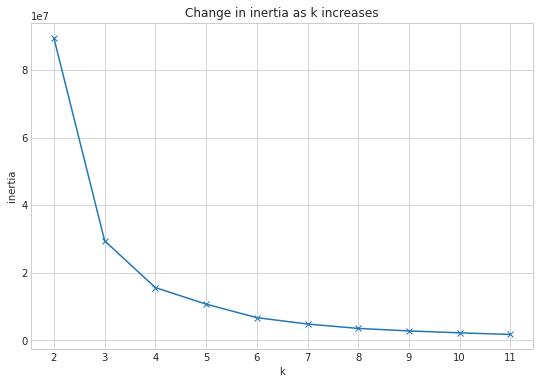

In [63]:
X = df_tcg[['net_sales']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [26]:


cols = ['net_sales']

X = df_bg[cols]

model = DBSCAN().fit(X)

df_bg['cluster'] = model.labels_

df_bg.cluster.value_counts()

-1    292
 0     11
 6     11
 2      8
 5      7
 1      6
 3      6
 4      6
Name: cluster, dtype: int64

In [31]:
df_bg

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,tenure,cluster
0,3,2,0,0,1,0,5,1,0,12,175.37,33,-1
7,0,1,0,0,0,0,0,0,0,1,62.99,0,-1
10,0,1,0,0,0,0,0,0,0,1,59.99,0,0
11,0,1,0,0,0,0,0,0,0,1,59.99,0,0
14,0,1,1,0,0,0,0,0,0,2,64.74,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,0,2,0,0,0,0,0,0,0,2,93.48,0,-1
1570,0,1,0,0,0,0,1,0,0,2,64.98,0,1
1573,0,1,0,0,0,0,0,0,0,1,39.99,0,6
1577,0,1,0,11,0,0,0,0,0,12,84.50,0,-1


In [33]:
df_bg[df_bg.cluster == 0]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,tenure,cluster
10,0,1,0,0,0,0,0,0,0,1,59.99,0,0
11,0,1,0,0,0,0,0,0,0,1,59.99,0,0
82,0,1,0,0,0,0,0,0,0,1,59.99,0,0
121,0,1,0,0,0,0,0,0,0,1,59.99,0,0
229,0,1,0,0,0,0,0,0,0,1,59.99,0,0
239,0,2,0,0,0,0,0,0,0,2,59.98,34,0
285,0,1,0,0,1,0,0,0,0,2,59.98,0,0
1036,0,1,0,0,0,0,0,0,0,1,59.99,0,0
1048,0,2,0,0,0,0,0,0,0,2,59.98,0,0
1234,0,1,0,0,0,0,0,0,0,1,59.99,29,0


In [34]:
df_bg[df_bg.cluster == 1]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,tenure,cluster
14,0,1,1,0,0,0,0,0,0,2,64.74,0,1
57,0,1,0,0,0,0,0,1,0,2,64.98,0,1
309,0,2,0,0,0,0,0,0,0,2,64.78,0,1
991,4,2,0,0,0,0,0,0,0,6,64.94,4,1
1224,1,1,0,0,0,0,0,0,0,2,64.58,0,1
1570,0,1,0,0,0,0,1,0,0,2,64.98,0,1


In [36]:
df_bg[df_bg.cluster == 2]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,tenure,cluster
60,0,1,0,0,0,0,0,0,0,1,44.99,0,2
156,0,2,0,0,0,0,0,0,0,2,44.98,0,2
370,0,1,0,0,0,0,0,0,0,1,44.99,0,2
556,0,1,0,0,0,0,0,0,0,1,44.99,0,2
759,0,1,0,0,0,0,0,0,0,1,44.99,0,2
901,0,1,0,0,0,0,1,0,0,2,44.98,0,2
1282,0,1,0,0,0,0,0,0,0,1,44.99,0,2
1308,2,1,0,0,0,0,0,0,0,3,44.97,5,2


In [37]:
df_bg[df_bg.cluster == 3]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales,tenure,cluster
127,2,1,0,0,0,0,0,0,0,3,34.98,0,3
325,0,1,0,0,0,0,0,0,0,1,34.99,0,3
550,0,2,0,0,0,0,0,0,0,2,34.99,0,3
690,0,1,2,0,0,0,0,0,0,3,35.49,0,3
861,0,2,0,0,0,0,0,0,0,2,34.98,0,3
1034,0,1,0,0,0,0,0,0,0,1,34.99,0,3


In [7]:
df_cats = df[['accessories', 
                  'board_games', 
                  'concessions', 
                  'modeling_supplies',
                  'role_playing_games', 
                  'minis_models', 
                  'trading_card_games', 
                  'other',
                  'game_room_rental', 
                  'all_items',
                  'net_sales']]

In [8]:
df_cats

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,other,game_room_rental,all_items,net_sales
0,3,2,0,0,1,0,5,1,0,12,175.37
1,4,0,0,0,0,0,0,3,0,7,105.30
2,0,0,4,0,0,0,0,0,1,5,29.38
3,0,0,0,0,0,0,3,1,0,4,249.96
4,0,0,0,3,0,0,0,0,0,3,20.97
...,...,...,...,...,...,...,...,...,...,...,...
1581,1,0,0,0,0,0,0,0,0,1,12.99
1582,0,0,2,0,0,1,0,0,0,3,10.34
1583,0,0,0,0,0,0,12,0,0,12,295.88
1584,0,0,0,0,0,0,0,2,0,2,19.49


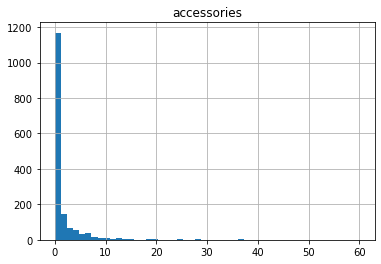

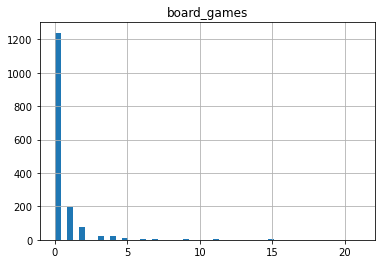

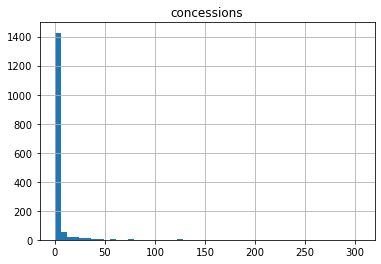

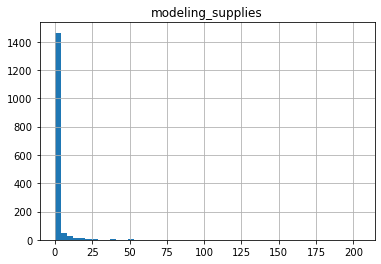

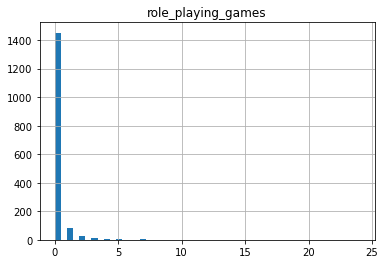

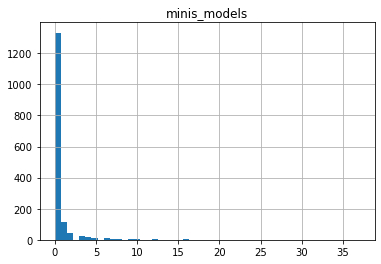

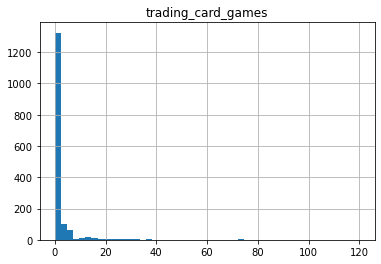

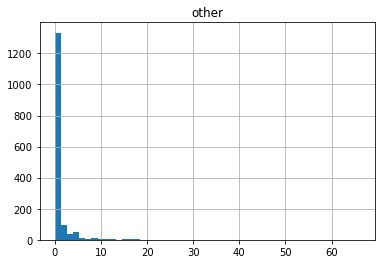

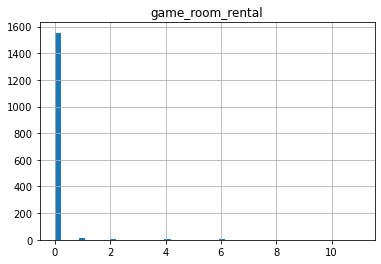

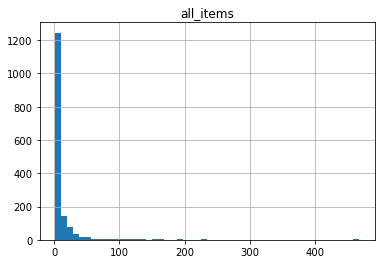

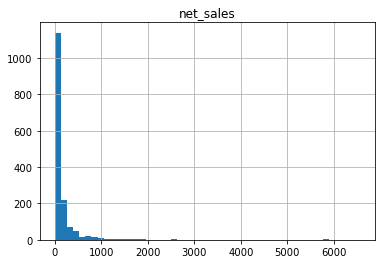

In [9]:
cols = ['accessories', 
        'board_games', 
        'concessions', 
        'modeling_supplies',
        'role_playing_games', 
        'minis_models', 
        'trading_card_games', 
        'other',
        'game_room_rental', 
        'all_items',
        'net_sales']

for col in cols:
    
    df[cols].hist(col, bins = 50)
    plt.show()
    
    

array([[<AxesSubplot:title={'center':'accessories'}>]], dtype=object)

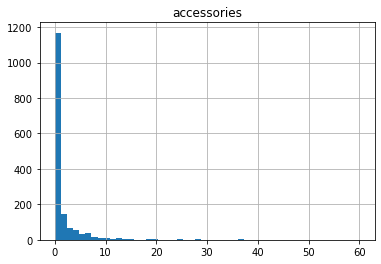

In [10]:
df.hist('accessories', bins = 50)

In [11]:
df[raw_num].describe()

NameError: name 'raw_num' is not defined

In [ ]:
for col in raw_num:
    
    print()
    print(col.upper())
    print()
    print (f'{round(len(df[df[col] > 0]) / len(df)*100)}% buyers')
    print (f'{round(len(df[df[col] == 0]) / len(df)*100)}% NON-buyers')
    

In [ ]:
df[raw_num]

In [ ]:
df[raw_num][df.trading_card_games > 0].describe()

In [ ]:
df[raw_num][df.accessories > 0].describe()

In [ ]:
df[raw_num][df.concessions > 0].describe()

In [ ]:
df[raw_num][df.modeling_supplies > 0].describe()

In [ ]:
sns.heatmap(df)

In [ ]:
cols = ['accessories', 
        'board_games', 
        'concessions',
        'modeling_supplies', 
        'role_playing_games', 
        'minis_models',
        'trading_card_games',
        'game_room']

for col in cols:
    
    
    print(col, 'Hist')
    
    plt.hist(df[raw_num][df[col] > 0])
    
    plt.show()